In [19]:
import pyemma.coordinates as coor
import numpy as np
from blues import utils
import mdtraj as md
import matplotlib
%matplotlib inline
#matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import numpy as np
import copy
import os, glob
from pathlib import PurePath

In [20]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def chunks(dihedral_traj, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(dihedral_traj), n):
        yield dihedral_traj[i:i + n]
def get_error(traj, n_samples=10):
    len_traj = traj.n_frames
    ten_split = round(len_traj/float(n_samples))
    traj_parts = chunks(traj, ten_split)
    four_range = [[-np.pi, -1.9], [-1.5,0], [0,1.25], [1.5,np.pi]]
    dev_list = []
    count_storage = np.zeros((n_samples, 4))
    for index, frame in enumerate(traj_parts):
        for i in four_range:
            if frame > i[0] and frame <= i[1]:
                count_storage[index, i] = count_storage[index, i] + 1
    count_storage = count_storage / float(len_traj)
    for j in range(len(n_samples)):
        avg_portion = count_storage[j,:]
        dev_list.append(avg_portion)
   # print('dev_list', dev_list)
    chunk_dev = np.std(dev_list)
  #  print('chunk_dev', chunk_dev)



    return count_storage

def get_error_edit(dihedral_traj, n_samples=5):
    len_traj = len(dihedral_traj)
    ten_split = int(round(len_traj/float(n_samples)))
    traj_parts = chunks(dihedral_traj, ten_split)
    four_range = [[-np.pi, -1.5], [-1.5,0], [0,1.5], [1.5,np.pi]]
    dev_list = []
    count_storage = np.zeros((n_samples, 4))
    ### PROBLEM IS HERE
    for index, chunk_frames in enumerate(traj_parts):
        for frame in chunk_frames:
            for coord_index, i in enumerate(four_range):
                if frame > i[0] and frame <= i[1]:
                    count_storage[index, coord_index] = count_storage[index, coord_index] + 1
    #print('storagebefore', count_storage)
    count_storage = count_storage / float(len(chunk_frames))
    for j in range(len(four_range)):
        avg_portion = np.std(count_storage[:,j])
        dev_list.append(avg_portion)
   # print('dev_list', dev_list)
    #print('count_matrix', count_storage)

    chunk_dev = np.std(dev_list)
    #print('chunk_dev', chunk_dev)



    return count_storage



def get_pcoord(traj, begin_fraction=0.0, fraction=1.0, showplot=False, outname=None, n_samples=5):
    frames = traj.n_frames

    fraction = fraction
    if 1: #split into four
        angle_index = np.array([[1846, 2634, 2638, 2640]])  #separates into two groups
    #    angle_index = np.array([[1638, 2634, 2637, 2640]])

        four_output = md.compute_dihedrals(traj, angle_index)
        #print('len_four output', len(four_output))
        four_range = [[-np.pi, -1.5], [-1.5,0], [0,1.5], [1.5,np.pi]]

    if 1: #split into two (nicer)
        angle_index = np.array([[1638, 1622, 2634, 2640]])  #separates into two groups


        two_output = md.compute_dihedrals(traj, angle_index)
        two_range = [[-3.14,-1], [1,3.14]]

    new_frames = int(round(fraction*frames))
    start_frames = int(round(begin_fraction*frames))
    four_output = four_output[:new_frames]
    two_output = two_output[:new_frames]
   # print('new_frames', new_frames, 'start_frames', start_frames, 'four_output', four_output)
    error_output = four_output[start_frames:new_frames]
    n_samp_inblock =  len(error_output)

    #std_list = get_error_edit(error_output)
    partial_counts = get_error_edit(error_output, n_samples=n_samples)
   #print(frames)
    #number of bins
    num_bins=360
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,10))
    ax1.scatter(range(new_frames), four_output, marker='_', s=2)
    ax1.set_xlabel('frame')
    ax1.set_ylabel('radians')
    ax2.hist(four_output, bins=num_bins)
    ax2.set_xlabel('radians')
    ax2.set_ylabel('counts')

    ax3.scatter(range(new_frames), two_output, marker='_', s=2)
    ax3.set_xlabel('frame')
    ax3.set_ylabel('radians')
    ax4.hist(two_output, bins=num_bins)
    ax4.set_xlabel('radians')
    ax4.set_ylabel('counts')

    #plt.scatter(range(frames), angle_output)
    hist_array = np.histogram(two_output, bins=num_bins)
    if 1:
        hist_counts = hist_array[0]
        bin_edges = hist_array[1]
        counts_list = []


        for entry in two_range:
            first, last = np.digitize(entry, bin_edges)
            counts_list.append(np.sum(hist_counts[first:last]))
       # print(counts_list)
        for index, entry in enumerate(counts_list):
            counts_list[index] = float(counts_list[index])

        counts_list = np.array(counts_list)
        counts_list = counts_list/np.sum(counts_list)
        two_stats = counts_list[:]
        #print(counts_list)
        #second time
        hist_array = np.histogram(four_output, bins=num_bins)

        hist_counts = hist_array[0]
        bin_edges = hist_array[1]
        counts_list = []

        for entry in four_range:
            first, last = np.digitize(entry, bin_edges)
            counts_list.append(np.sum(hist_counts[first:last]))
        #print(counts_list)
        for index, entry in enumerate(counts_list):
            counts_list[index] = float(counts_list[index])

        counts_list = np.array(counts_list)
        counts_list = counts_list/np.sum(counts_list)
        four_stats = counts_list[:]
        #print(counts_list)

    plt.xlim([-np.pi,np.pi])
    if outname is not None:
        plt.savefig(outname)

    if showplot:
        plt.show()
    plt.close()
    partial_counts = np.array(partial_counts)
    return two_stats, four_stats, partial_counts

def graph_convergence(stats_dict, title, beginning_data=None, error=True, add_labels=True, show=False, fig_present=False):
    conv_range = sorted([i for i in stats_dict])
    first, second, third, fourth = [], [], [], []
    first_err, second_err, third_err, fourth_err = [], [], [], []
    for i, skey in enumerate(sorted(stats_dict)):
        two, four, partial_counts = stats_dict[skey]
        first.append(four[0])
        second.append(four[1])
        third.append(four[2])
        fourth.append(four[3])
        if i == 0:
            total_counts = partial_counts
        else:
            total_counts = np.concatenate((total_counts, partial_counts))
        first_err.append(np.std(total_counts[:,0])/np.sqrt(float(np.shape(total_counts)[0])))
        second_err.append(np.std(total_counts[:,1])/np.sqrt(float(np.shape(total_counts)[0])))
        third_err.append(np.std(total_counts[:,2])/np.sqrt(float(np.shape(total_counts)[0])))
        fourth_err.append(np.std(total_counts[:,3])/np.sqrt(float(np.shape(total_counts)[0])))
        
    if fig_present == False:
        fig = plt.figure(figsize=cm2inch((17,8)))
    if error == True:
        plt.errorbar(conv_range, second, yerr=second_err, marker='s', capthick=2, color='blue', ms=6, linewidth=1.5, label='A=%.2f' % (second[-1]+fourth[-1]))
        plt.errorbar(conv_range, fourth, yerr=fourth_err, marker='s', capthick=2, color='darkturquoise', ms=6, linewidth=1.5)
        plt.errorbar(conv_range, first, yerr=first_err, marker='^', capthick=2, color='red', ms=6, linewidth=1.5, label='B=%.2f' % (first[-1]+third[-1]))
        plt.errorbar(conv_range, third, yerr=third_err, marker='^', capthick=2, color='darkorange', ms=6, linewidth=1.5)
    if beginning_data is not None:
        conv_range = (sorted([i for i in beginning_data]))
        first, second, third, fourth = [], [], [], []
        for i, skey in enumerate(sorted(beginning_data)):
            two, four, partial_counts = beginning_data[skey]
            first.append(four[0])
            second.append(four[1])
            third.append(four[2])
            fourth.append(four[3])

        plt.plot(conv_range, second, '-s', color='blue', ms=6, linewidth=1.5)
        plt.plot(conv_range, fourth, '-s', color='darkturquoise', ms=6, linewidth=1.5)
        plt.plot(conv_range, first, '-^', color='red', ms=6, linewidth=1.5)
        plt.plot(conv_range, third, '-^', color='darkorange', ms=6, linewidth=1.5)

    if add_labels == True:
        plt.legend(loc='best', fancybox=True, framealpha=0.5)

    conv_points = np.arange(0,1.00+0.02, 0.02)
    aline = [0.3 for x in range(len(conv_points))]
    bline = [0.2 for x in range(len(conv_points))]
 
    plt.plot(conv_points, aline, color='b', linestyle='-.')
    plt.plot(conv_points, bline, color='r', linestyle='-.')
    plt.xlabel('Fraction of simulation time')
    plt.ylabel('Probability of state')
    plt.ylim(0.1,0.6)
    plt.xlim(0,1.01)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png')
    if show==True:
        plt.show()
    if fig_present == False:
        return fig, [first_err[-1], second_err[-1], third_err[-1], fourth_err[-1]]
    else:
        return fig, [first_err[-1], second_err[-1], third_err[-1], fourth_err[-1]]



In [21]:

def dihedral_analysis(traj, graph_outname):
    stats = {}
    bstats = {}
    small_range = np.arange(0.04,0.12, 0.02)
    grange = np.arange(0.1,1.1, 0.1)
    total_range = grange
    begin_fraction = 0.0
    n_samples = 10
    if 0:
        #checks the blocks used and graphs the std
        fig1, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)

        block_size = [5, 5, 2, 1]

        for color, block, in zip(['r','g','b','k'], block_size):
            one1, two1, three1, four1 = [], [], [], []
            for fract in total_range:
                #two, four = get_pcoord(traj, begin_fraction=begin_fraction, fraction=fract, showplot=True, n_samples=block)

                two, four, std_list = get_pcoord(traj, begin_fraction=begin_fraction, fraction=fract, showplot=True, n_samples=block)
                stats[fract] = [two, four, std_list]
                begin_fraction = fract
                fig, std = graph_convergence(stats, beginning_data=bstats, show=False, add_labels=True)
        #        fig, std = graph_convergence(stats, show=False, add_labels=False)

                plt.close(fig)
                one1.append(std[0])
                two1.append(std[1])
                three1.append(std[2])
                four1.append(std[3])

            begin_fraction = 0.0
            for step, ax in zip([one1, two1, three1, four1], [ax1, ax2, ax3, ax4]):
                ax.scatter(range(len(step)), step, color=color, marker='o', label=str(block))
        plt.legend()
        plt.show()
    if 1:
        begin_fraction = 0.0
        for fract in total_range:
            two, four, std_list = get_pcoord(traj, begin_fraction=begin_fraction, fraction=fract, showplot=False, n_samples=n_samples)
            stats[fract] = [two, four, std_list]
            begin_fraction = fract
        fig, std = graph_convergence(stats, beginning_data=bstats, error=True, show=True, add_labels=True, title=graph_outname)


In [22]:
pdbfiles = glob.glob('t4tol-*/*-centered.pdb')
trajfiles = glob.glob('t4tol-*/*-centered.nc')
len(trajfiles)
print(trajfiles)

['t4tol-595615_5/t4tol-595615_5-centered.nc', 't4tol-595615_2/t4tol-595615_2-centered.nc', 't4tol-595615_7/t4tol-595615_7-centered.nc', 't4tol-595615_6/t4tol-595615_6-centered.nc', 't4tol-595615_1/t4tol-595615_1-centered.nc', 't4tol-595615_3/t4tol-595615_3-centered.nc', 't4tol-595615_0/t4tol-595615_0-centered.nc', 't4tol-595615_4/t4tol-595615_4-centered.nc']


In [23]:
def centerTrajectory(traj, outfname):
    #Recenter/impose periodicity to the system
    anchor = traj.top.guess_anchor_molecules()[0]
    imgd = traj.image_molecules(anchor_molecules=[anchor])
    #Let's align by the protein atoms in reference to the first frame
    prt_idx = imgd.top.select('protein')
    superposed = imgd.superpose(reference=imgd, frame=0, atom_indices=prt_idx)
    #Save out the aligned frames
    superposed = superposed.remove_solvent()
    superposed.save_netcdf(outfname + '-centered.nc')
    superposed[0].save_pdb(outfname + '-centered.pdb')

<mdtraj.Trajectory with 5000 frames, 2649 atoms, 165 residues, and unitcells>


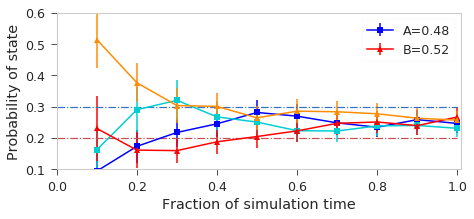

<mdtraj.Trajectory with 5000 frames, 2649 atoms, 165 residues, and unitcells>


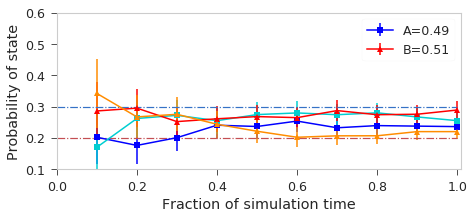

<mdtraj.Trajectory with 5000 frames, 2649 atoms, 165 residues, and unitcells>


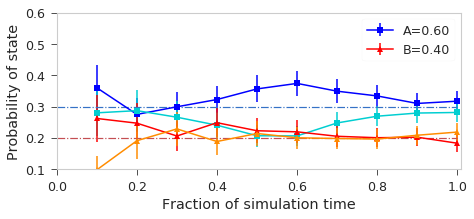

<mdtraj.Trajectory with 5000 frames, 2649 atoms, 165 residues, and unitcells>


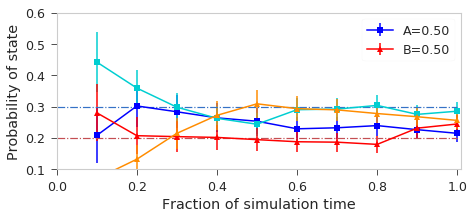

<mdtraj.Trajectory with 5000 frames, 2649 atoms, 165 residues, and unitcells>


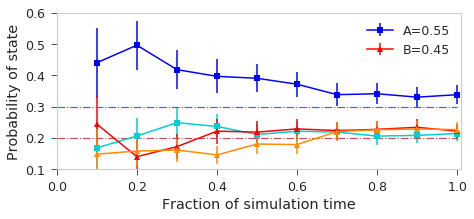

<mdtraj.Trajectory with 5000 frames, 2649 atoms, 165 residues, and unitcells>


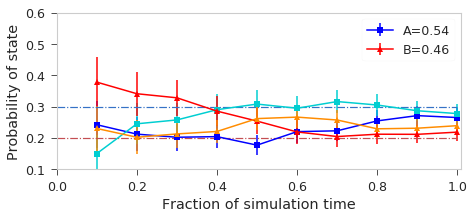

<mdtraj.Trajectory with 5000 frames, 2649 atoms, 165 residues, and unitcells>


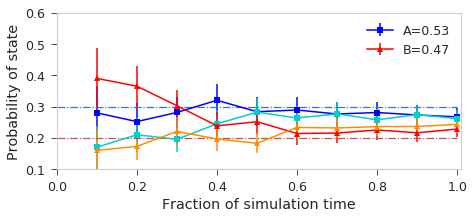

<mdtraj.Trajectory with 5000 frames, 2649 atoms, 165 residues, and unitcells>


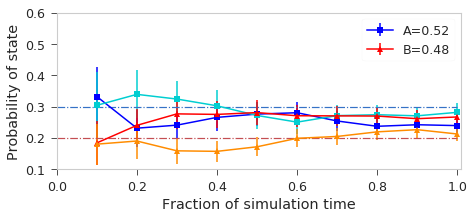

In [18]:
for trj,pdb in zip(trajfiles,pdbfiles):
    outname = trj.rstrip('-centered.nc')
    #print(outname)
    traj = md.load(trj, top=pdb, stride=1)
    traj = traj[2:] #Must slice evenly 5002 --> 5000 frames
    #centerTrajectory(traj, outname)
    #print(traj)
    dihedral_analysis(traj, outname)

# Combine work values from .log files using
`for log in t4tol*/*.log; do echo $log; fname=${log%*.log}; grep ': work_ncmc' $log > ${fname}.dat; done`

In [72]:
datfiles = glob.glob('t4tol-*/*.dat')
work_ncmc = {}
for dat in datfiles:
    txt = np.genfromtxt(dat, dtype=str, delimiter=':')
    work_values = []
    accepted = 0
    for line in txt:
        if 'ACCEPTED' in str(line):
            accepted+=1
        l = line[-1].split(' ')
        work_values.append(float(l[2]))
    accept = accepted/len(work_values)
    work_ncmc[dat] = (work_values, accept)

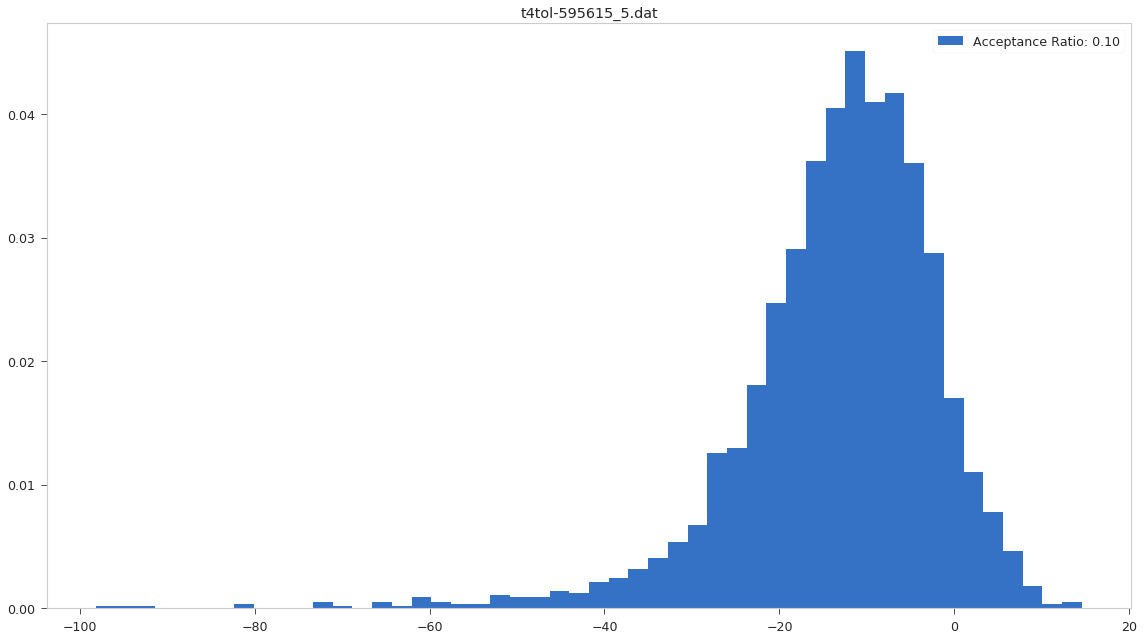

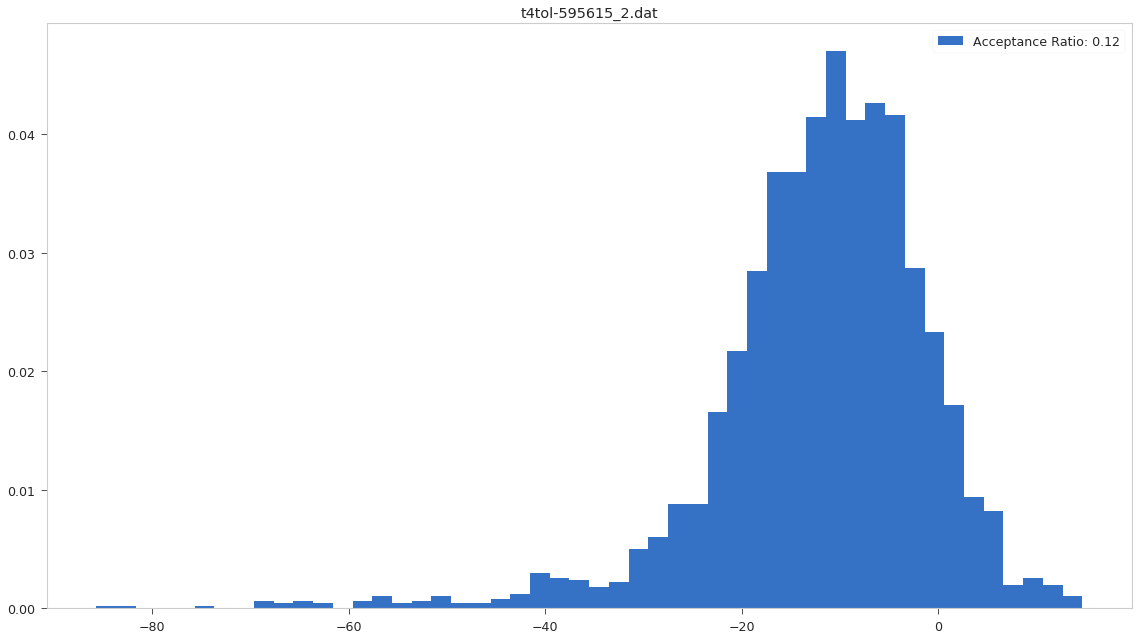

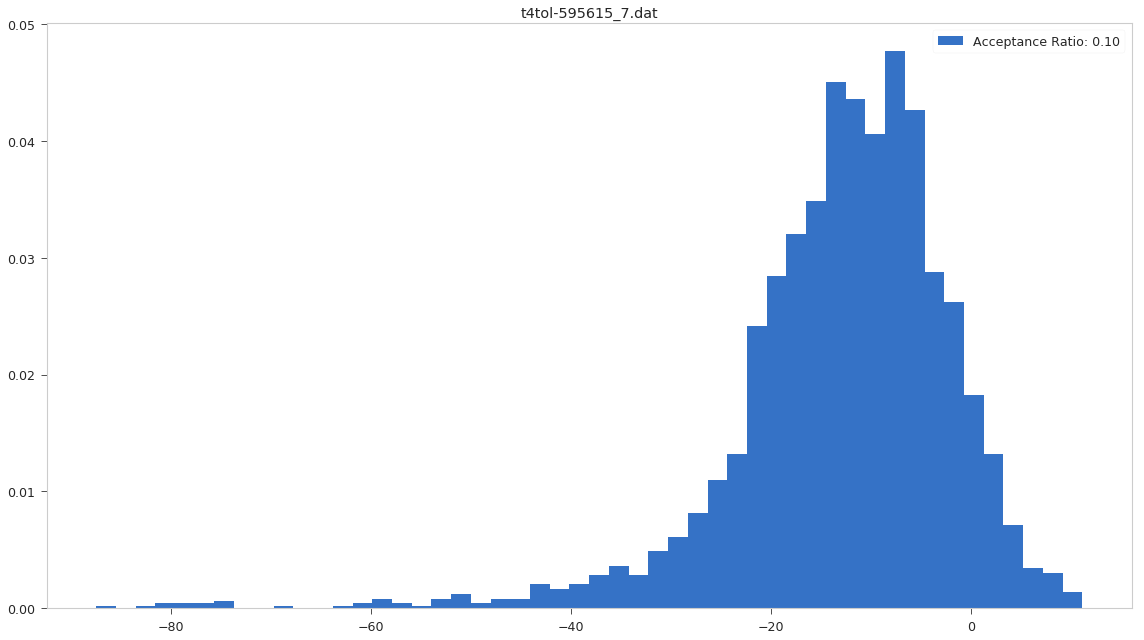

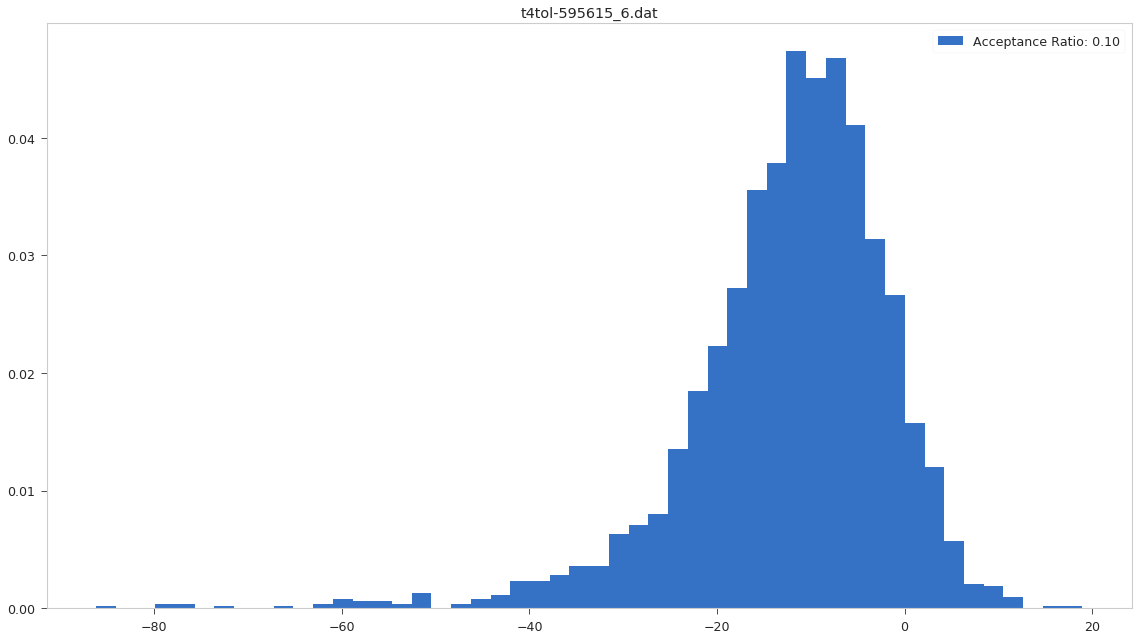

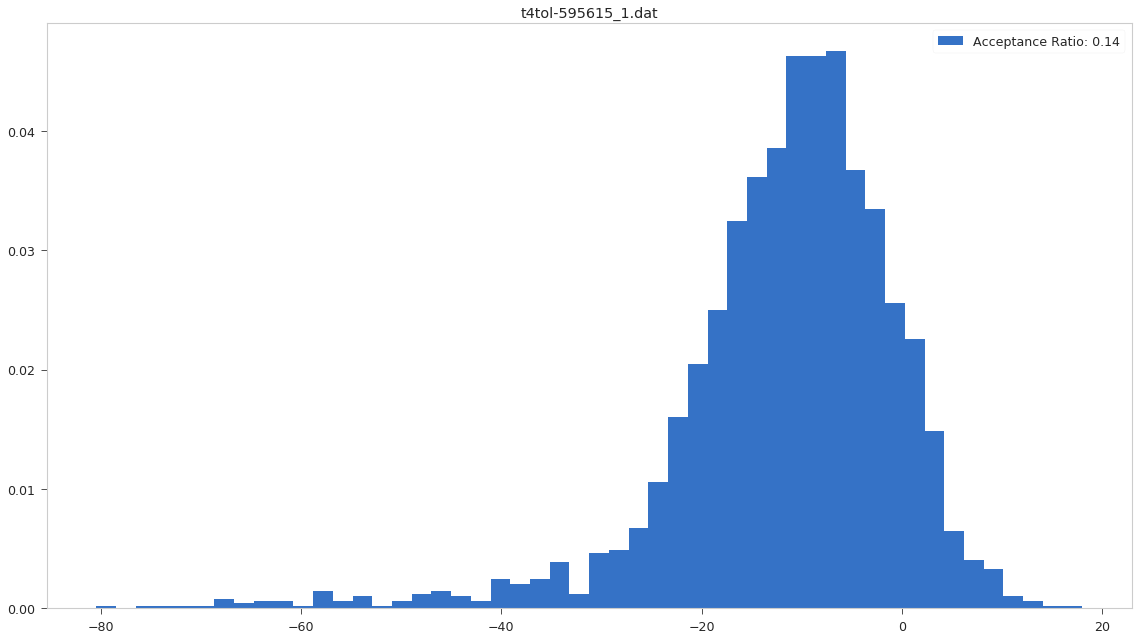

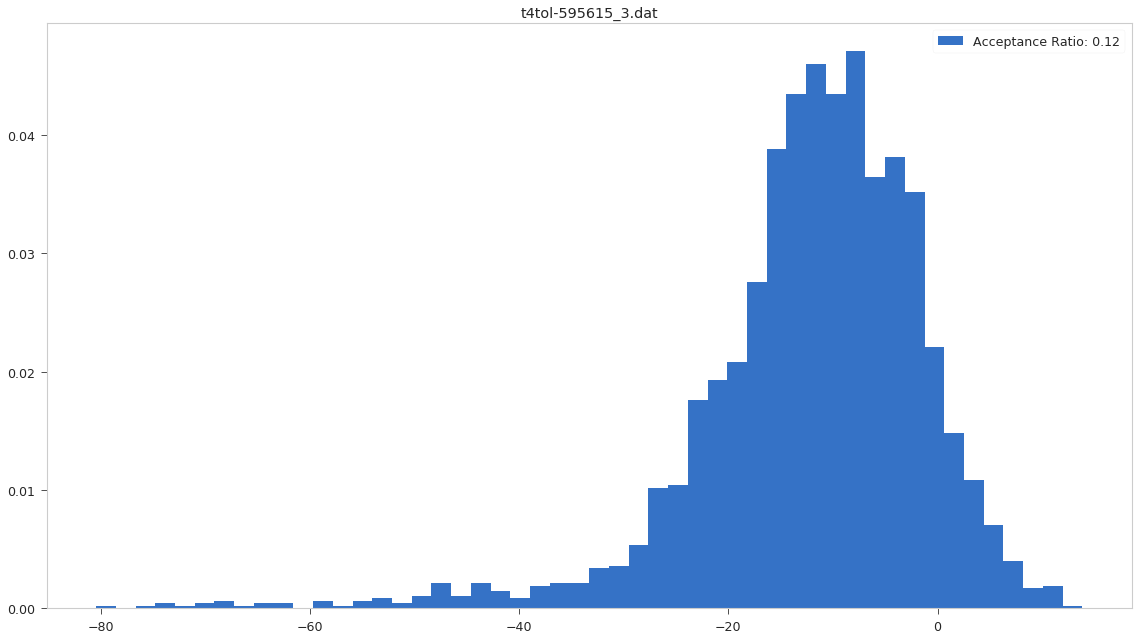

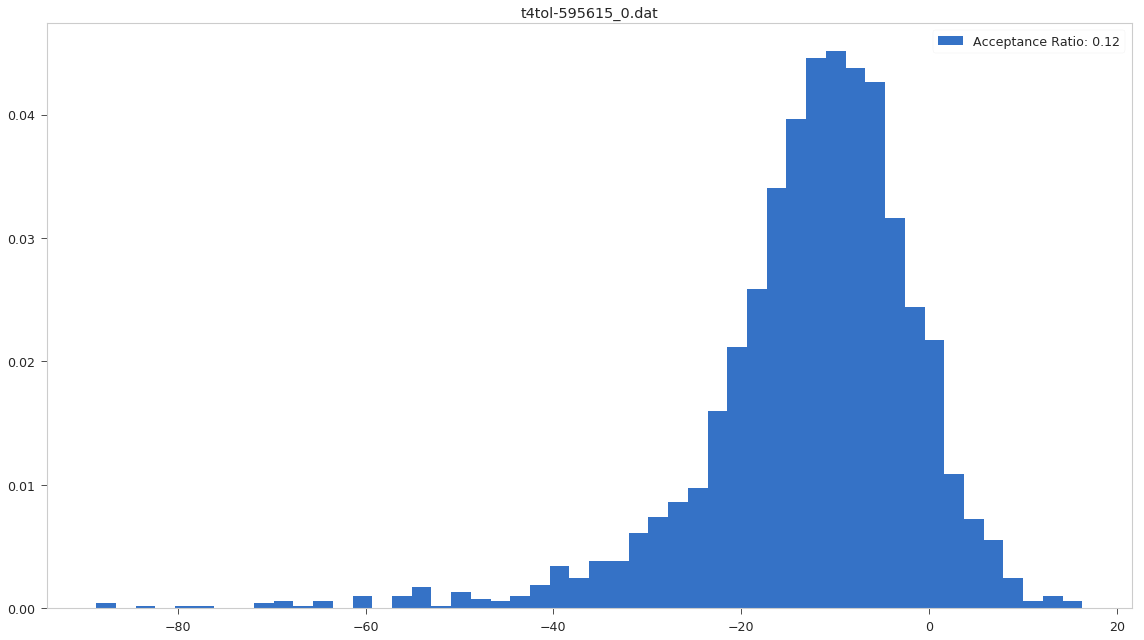

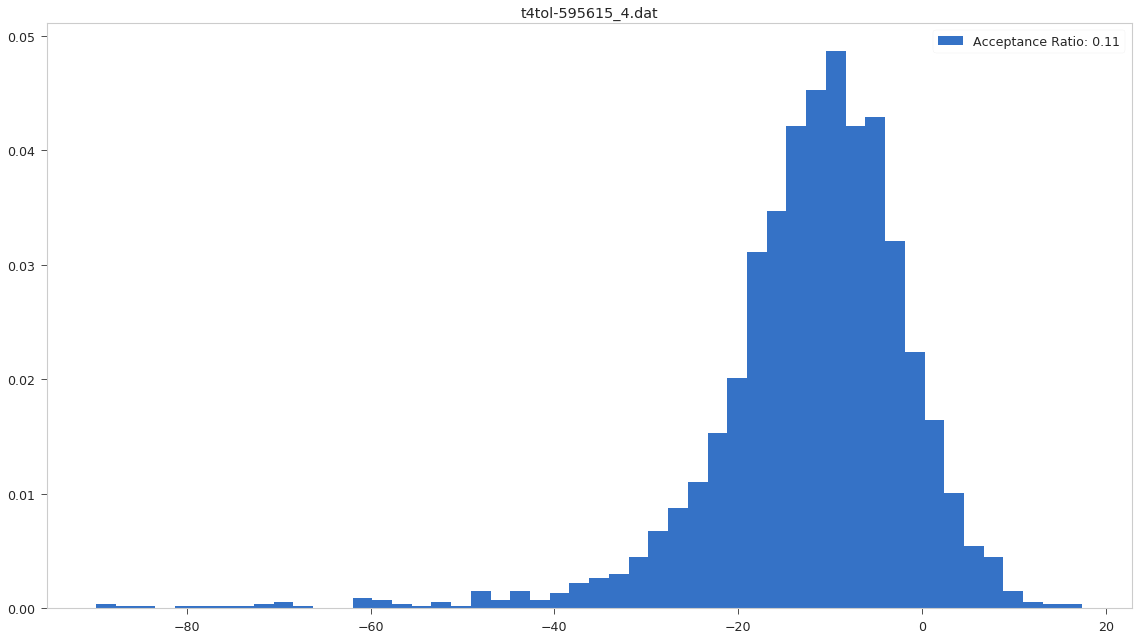

In [74]:
for k,v in work_ncmc.items():
    title = k.split('/')[-1]
    fig = plt.figure(figsize=(16,9))
    plt.hist(v[0], bins=50, density=1, label='Acceptance Ratio: %.2f'% v[1])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()